In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
!python -V

Python 3.9.20


In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error



In [19]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")

mlflow.set_experiment("nyc-taxi-experiment_2")



<Experiment: artifact_location='/workspaces/mlops-zoomcamp/03-training/experiment_tracking/mlruns/4', creation_time=1733506662911, experiment_id='4', last_update_time=1733506662911, lifecycle_stage='active', name='nyc-taxi-experiment_2', tags={}>

In [5]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df['duration'] = df.duration.apply(lambda td: td.total_seconds() / 60 )
    
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']    
    
    df[categorical] = df[categorical].astype(str)
    
    return df

In [6]:
df_train = read_dataframe('data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('data/green_tripdata_2021-02.parquet')

In [7]:
len(df_train), len(df_val)

(73908, 61921)

In [8]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [9]:
categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)


In [10]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [11]:
lr = LinearRegression()
lr.fit(X_train,y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


np.float64(7.758715208009878)

In [12]:
lr = Ridge()
lr.fit(X_train,y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


np.float64(7.70373515548786)

/tmp/ipykernel_37456/1505421196.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_37456/1505421196.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


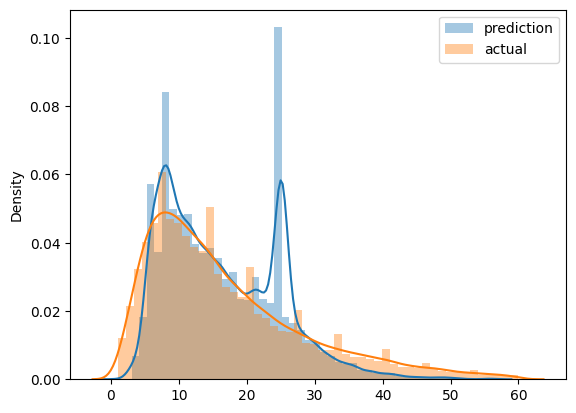

In [13]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend()

In [14]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv,lr), f_out) #guardamos el diccionario vectorizado y el modelo

In [15]:
mlflow.end_run()

In [16]:
mlflow.end_run()
with mlflow.start_run():
    mlflow.autolog()
    
    mlflow.set_tag("developer", "javier")
    
    mlflow.log_param("train-data-path", "data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "data/green_tripdata_2021-02.parquet")    
    
    
    alpha= 0.1
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train,y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    mlflow.log_artifact(local_path= "models/lin_reg.bin", artifact_path= "model_pickle")

2024/12/09 10:10:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/12/09 10:10:42 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'


: 

In [15]:
#Intentar registrar un modelo con linear regresion
mlflow.end_run()
with mlflow.start_run():
    mlflow.autolog()
    
    mlflow.set_tag("developer", "javier")
    
    mlflow.log_param("train-data-path", "data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "data/green_tripdata_2021-02.parquet")    
            
    
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    mlflow.log_artifact(local_path= "models/lin_reg.bin", artifact_path= "model_pickle")

2024/12/09 10:09:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/12/09 10:09:34 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'


: 

In [1]:
mlflow.end_run()

NameError: name 'mlflow' is not defined

In [ ]:


from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}



In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), #exp(-3), exp(0) - [0,05 -1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

In [25]:
mlflow.xgboost.autolog(disable=True)

In [28]:
import xgboost as xgb

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

with mlflow.start_run():
    best_params = {
    'learning_rate' : 0.09585355369315604,    
    'max_depth': 30,    
    'reg_alpha': 0.01806024404006163,
    'reg_lambda': 0.011658731377413597,
    'min_child_weight': 1.060597050922164 ,
    'objective': 'reg:linear',
    'seed': 42
}
    
mlflow.log_params(best_params)

booster = xgb.train(
    params= best_params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

y_pred= booster.predict(valid)
rmse= mean_squared_error(y_val, y_pred, squared=False)
mlflow.log_metric("rmse", rmse)

with open("models/preprocessor.b", "wb") as f_out:
    pickle.dump(dv, f_out)
    

mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

mlflow.xgboost.log_model(booster, artifact_path="models_mlflow") 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:57:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.44482
[1]	validation-rmse:10.77202
[2]	validation-rmse:10.18363
[3]	validation-rmse:9.67396
[4]	validation-rmse:9.23166
[5]	validation-rmse:8.84808
[6]	validation-rmse:8.51883


KeyboardInterrupt: 

In [27]:
mlflow.end_run()

In [29]:
logged_model = 'runs:/ed7175b8c6854619af44473c42d9c443/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)



In [30]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: ed7175b8c6854619af44473c42d9c443

In [31]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

In [32]:
xgboost_model

In [33]:
y_pred = xgboost_model.predict(valid)

In [34]:
y_pred[:10]

array([14.782765 ,  7.184751 , 15.971323 , 24.328938 ,  9.559302 ,
       17.115105 , 11.6522455,  8.688133 ,  8.962229 , 18.982166 ],
      dtype=float32)

In [6]:
all_runs = mlflow.search_runs(search_all_experiments=True)

In [7]:
print(all_runs)

                              run_id experiment_id    status  \
0   b782909a29834e509a22c59480bd6bf5             4   RUNNING   
1   9ef0ab4709f04585ae6d5b4499601091             4   RUNNING   
2   bb90af433fe6458b9289d6522b2503c1             4   RUNNING   
3   4a95116df67b4109a1d0755e74c70d25             4  FINISHED   
4   21477be0c97a4a0f87f7be6a098afd60             4   RUNNING   
5   406fa1f7a1344084894c39582caf1471             4  FINISHED   
6   faedb34359184516b87386c3d3874161             4   RUNNING   
7   974b3717210e4087977ababddc454a44             4   RUNNING   
8   99161c650c0f4e0aaf32886385c711f5             4  FINISHED   
9   ab888fae7fd445ffb4fe3780100a2059             4  FINISHED   
10  01cf014781a14ca2a60592c783218175             4  FINISHED   
11  756010995fcd471b806871b3e679e189             4   RUNNING   
12  6d8d334376df46e0adbc79a676407f2c             4    FAILED   
13  e46c48b0d81d4a4299aa5842e130e876             4    FAILED   
14  7d1aab7c8a614b31bfb89f66cf93d68a    

In [9]:
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

client = MlflowClient(tracking_uri = MLFLOW_TRACKING_URI)

In [32]:
from mlflow.entities import ViewType
runs = client.search_runs(
    experiment_ids="4",
    filter_string="metrics.rmse < 6.8",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"]
)

In [33]:
print(runs)

[<Run: data=<RunData: metrics={'rmse': 6.318445793399953}, params={'learning_rate': '0.09585355369315604',
 'max_depth': '30',
 'min_child_weight': '1.060597050922164',
 'objective': 'reg:linear',
 'reg_alpha': '0.01806024404006163',
 'reg_lambda': '0.011658731377413597',
 'seed': '42'}, tags={'mlflow.log-model.history': '[{"run_id": "ed7175b8c6854619af44473c42d9c443", '
                             '"artifact_path": "models_mlflow", '
                             '"utc_time_created": "2024-12-09 '
                             '09:32:57.188301", "model_uuid": '
                             '"93c49110b7304c1fbbaf728537c95730", "flavors": '
                             '{"python_function": {"loader_module": '
                             '"mlflow.xgboost", "python_version": "3.9.20", '
                             '"data": "model.xgb", "env": {"conda": '
                             '"conda.yaml", "virtualenv": "python_env.yaml"}}, '
                             '"xgboost": {"xgb_version

In [34]:
for run in runs:
    print(f"run id: {run.info.run_id}, rmse: {run.data.metrics['rmse']:.4f}")

run id: ed7175b8c6854619af44473c42d9c443, rmse: 6.3184
run id: 26d6b3bcdb914fbbb3544ae345f17af6, rmse: 6.3184
run id: 442c90113b844f49aa75370fc67eea0f, rmse: 6.3224
run id: 0c5f94dc41c3488ebaf696fb7cb55551, rmse: 6.3263
run id: dba4717c2c69482898ef6baf322e39ab, rmse: 6.4654


In [35]:
import mlflow

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)


In [65]:
run_id= "ed7175b8c6854619af44473c42d9c443"
model_uri= f"runs:/{run_id}/model"

mlflow.register_model(model_uri=model_uri , name="nyc-taxi-xboost")

Registered model 'nyc-taxi-xboost' already exists. Creating a new version of this model...
Created version '4' of model 'nyc-taxi-xboost'.


<ModelVersion: aliases=[], creation_timestamp=1733747542645, current_stage='None', description=None, last_updated_timestamp=1733747542645, name='nyc-taxi-xboost', run_id='ed7175b8c6854619af44473c42d9c443', run_link=None, source='/workspaces/mlops-zoomcamp/03-training/experiment_tracking/mlruns/4/ed7175b8c6854619af44473c42d9c443/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=4>

In [66]:
client.search_registered_models()

[<RegisteredModel: aliases={}, creation_timestamp=1733744636822, description=None, last_updated_timestamp=1733745013287, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1733745013287, current_stage='None', description=None, last_updated_timestamp=1733745013287, name='nyc-taxi-experiment_2', run_id='26d6b3bcdb914fbbb3544ae345f17af6', run_link=None, source='/workspaces/mlops-zoomcamp/03-training/experiment_tracking/mlruns/4/26d6b3bcdb914fbbb3544ae345f17af6/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>], name='nyc-taxi-experiment_2', tags={}>,
 <RegisteredModel: aliases={}, creation_timestamp=1733741371434, description='This is NYC Taxi prediction model\n', last_updated_timestamp=1733747542645, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1733745126888, current_stage='Staging', description=('The model version <ModelVersion: aliases=[], '
  "creation_timestamp=1733745126888, current_stage='None', description=None, 

In [67]:
model_name= "nyc-taxi-xboost"
latest_versions= client.get_latest_versions(name=model_name)

for version in latest_versions:
    print(f"version: {version.version}, stage {version.current_stage}")

version: 3, stage Staging
version: 4, stage None


/tmp/ipykernel_3082/3751737152.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest_versions= client.get_latest_versions(name=model_name)


In [68]:
model_version = 4
new_stage = "Staging"

client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions=False
)

/tmp/ipykernel_3082/651624992.py:4: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1733747542645, current_stage='Staging', description=None, last_updated_timestamp=1733747553842, name='nyc-taxi-xboost', run_id='ed7175b8c6854619af44473c42d9c443', run_link=None, source='/workspaces/mlops-zoomcamp/03-training/experiment_tracking/mlruns/4/ed7175b8c6854619af44473c42d9c443/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=4>

In [69]:
from datetime import datetime

date = datetime.today().date()
client.update_model_version(
    name=model_name,
    version= model_version,
    description=f"The model version {version} was transitioned to stage {new_stage} on date {date}"
)

<ModelVersion: aliases=[], creation_timestamp=1733747542645, current_stage='Staging', description=('The model version <ModelVersion: aliases=[], '
 "creation_timestamp=1733747542645, current_stage='None', description=None, "
 "last_updated_timestamp=1733747542645, name='nyc-taxi-xboost', "
 "run_id='ed7175b8c6854619af44473c42d9c443', run_link=None, "
 "source='/workspaces/mlops-zoomcamp/03-training/experiment_tracking/mlruns/4/ed7175b8c6854619af44473c42d9c443/artifacts/model', "
 "status='READY', status_message=None, tags={}, user_id=None, version=4> was "
 'transitioned to stage Staging on date 2024-12-09'), last_updated_timestamp=1733747554725, name='nyc-taxi-xboost', run_id='ed7175b8c6854619af44473c42d9c443', run_link=None, source='/workspaces/mlops-zoomcamp/03-training/experiment_tracking/mlruns/4/ed7175b8c6854619af44473c42d9c443/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=4>

In [70]:
from sklearn.metrics import mean_squared_error
import pandas as pd


def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df


def preprocess(df, dv):
    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']
    categorical = ['PU_DO']
    numerical = ['trip_distance']
    train_dicts = df[categorical + numerical].to_dict(orient='records')
    return dv.transform(train_dicts)


def test_model(name, stage, X_test, y_test):
    model = mlflow.pyfunc.load_model(f"models:/{name}/{stage}")
    y_pred = model.predict(X_test)
    return {"rmse": mean_squared_error(y_test, y_pred, squared=False)}

In [71]:
df = read_dataframe("data/green_tripdata_2021-03.parquet")

In [72]:
client.download_artifacts(run_id=run_id, path='preprocessor', dst_path='.')

'/workspaces/mlops-zoomcamp/03-training/experiment_tracking/preprocessor'

In [74]:
import pickle

with open("preprocessor/preprocessor.b", "rb") as f_in:
    dv=pickle.load(f_in)

In [76]:
X_test = preprocess(df,dv)

In [77]:
target = "duration"
y_test = df[target].values

In [81]:
%time test_model(name=model_name, stage= "Staging", X_test=X_test, y_test=y_test)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/mlflow/store/artifact/utils/models.py:31: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


OSError: No such file or directory: '/workspaces/mlops-zoomcamp/03-training/experiment_tracking/mlruns/4/ed7175b8c6854619af44473c42d9c443/artifacts/model/.'

In [82]:
client.transition_model_version_stage(
    name=model_name,
    version=4,
    stage="Production",
    archive_existing_versions=True
)

/tmp/ipykernel_3082/3610659809.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1733747542645, current_stage='Production', description=('The model version <ModelVersion: aliases=[], '
 "creation_timestamp=1733747542645, current_stage='None', description=None, "
 "last_updated_timestamp=1733747542645, name='nyc-taxi-xboost', "
 "run_id='ed7175b8c6854619af44473c42d9c443', run_link=None, "
 "source='/workspaces/mlops-zoomcamp/03-training/experiment_tracking/mlruns/4/ed7175b8c6854619af44473c42d9c443/artifacts/model', "
 "status='READY', status_message=None, tags={}, user_id=None, version=4> was "
 'transitioned to stage Staging on date 2024-12-09'), last_updated_timestamp=1733747874202, name='nyc-taxi-xboost', run_id='ed7175b8c6854619af44473c42d9c443', run_link=None, source='/workspaces/mlops-zoomcamp/03-training/experiment_tracking/mlruns/4/ed7175b8c6854619af44473c42d9c443/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=4>